## Import Packages

In [3]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Data Reading and Preprocessing

In [4]:
# Reading generated power (Solar and wind) data
# Dataset link : https://data.open-power-system-data.org/time_series/2020-10-06

data_path = r"C:\Users\Mohamed\OneDrive\Desktop\Graduation project\opsd-time_series-2020-10-06\time_series_60min_singleindex.csv"
kaggle_path = r"../input/wind-and-solar-generation-from-weather-data/time_series_60min_singleindex.csv"

df = pd.read_csv(data_path,
                 usecols=(lambda s: s.startswith('utc') | s.startswith('DE')),
                 parse_dates=[0], index_col=0)

In [5]:
# As we see in the last two graphs , The wind and solar power aer seasonal  

production_wind_solar = df[['DE_wind_generation_actual', 'DE_solar_generation_actual']]
production_wind_solar.head()

,DE_wind_generation_actual,DE_solar_generation_actual
utc_timestamp,,
2014-12-31 23:00:00+00:00,NaN,NaN
2015-01-01 00:00:00+00:00,8852.0,NaN
2015-01-01 01:00:00+00:00,9054.0,NaN
2015-01-01 02:00:00+00:00,9070.0,NaN
2015-01-01 03:00:00+00:00,9163.0,NaN


In [6]:
# Reading weather data to be combined with power data  
# https://data.open-power-system-data.org/weather_data/2020-09-16
# Metadata link : https://data.open-power-system-data.org/weather_data/2020-09-16/README.md


data_path = r"C:\Users\Mohamed\OneDrive\Desktop\Graduation project\opsd-weather_data-2020-09-16\weather_data.csv"
kaggle_path = r"../input/wind-and-solar-generation-from-weather-data/weather_data.csv"

weather = pd.read_csv(data_path, parse_dates=[0], index_col=0)
weather.head()

,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,BG_radiation_diffuse_horizontal,CH_temperature,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
1980-01-01 00:00:00+00:00,-3.640,0.0,0.0,-0.720,0.0,0.0,4.664,0.0,0.0,-6.287,...,0.0,-3.945,0.0,0.0,-3.055,0.0,0.0,-4.648,0.0,0.0
1980-01-01 01:00:00+00:00,-3.803,0.0,0.0,-1.165,0.0,0.0,4.052,0.0,0.0,-6.602,...,0.0,-4.053,0.0,0.0,-3.272,0.0,0.0,-4.554,0.0,0.0
1980-01-01 02:00:00+00:00,-3.969,0.0,0.0,-1.434,0.0,0.0,3.581,0.0,0.0,-6.981,...,0.0,-4.129,0.0,0.0,-3.639,0.0,0.0,-4.455,0.0,0.0
1980-01-01 03:00:00+00:00,-4.076,0.0,0.0,-1.843,0.0,0.0,3.197,0.0,0.0,-7.368,...,0.0,-4.139,0.0,0.0,-4.202,0.0,0.0,-4.421,0.0,0.0
1980-01-01 04:00:00+00:00,-4.248,0.0,0.0,-2.094,0.0,0.0,2.750,0.0,0.0,-7.849,...,0.0,-4.239,0.0,0.0,-4.732,0.0,0.0,-4.449,0.0,0.0


In [7]:
# resampling weather data by day to make it ready to be combined with power data  

weather_by_day = weather.groupby(weather.index).mean()
weather_by_day.head()

,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,BG_radiation_diffuse_horizontal,CH_temperature,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
1980-01-01 00:00:00+00:00,-3.640,0.0,0.0,-0.720,0.0,0.0,4.664,0.0,0.0,-6.287,...,0.0,-3.945,0.0,0.0,-3.055,0.0,0.0,-4.648,0.0,0.0
1980-01-01 01:00:00+00:00,-3.803,0.0,0.0,-1.165,0.0,0.0,4.052,0.0,0.0,-6.602,...,0.0,-4.053,0.0,0.0,-3.272,0.0,0.0,-4.554,0.0,0.0
1980-01-01 02:00:00+00:00,-3.969,0.0,0.0,-1.434,0.0,0.0,3.581,0.0,0.0,-6.981,...,0.0,-4.129,0.0,0.0,-3.639,0.0,0.0,-4.455,0.0,0.0
1980-01-01 03:00:00+00:00,-4.076,0.0,0.0,-1.843,0.0,0.0,3.197,0.0,0.0,-7.368,...,0.0,-4.139,0.0,0.0,-4.202,0.0,0.0,-4.421,0.0,0.0
1980-01-01 04:00:00+00:00,-4.248,0.0,0.0,-2.094,0.0,0.0,2.750,0.0,0.0,-7.849,...,0.0,-4.239,0.0,0.0,-4.732,0.0,0.0,-4.449,0.0,0.0


In [8]:
# Meging (Solar & wind) data with (weather) data

combined = pd.merge(production_wind_solar, weather_by_day, how='left', left_index=True, right_index=True)
combined.head()

,DE_wind_generation_actual,DE_solar_generation_actual,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,NaN,NaN,-6.495,0.0,0.0,0.100,0.0,0.0,-13.029,0.0,...,0.0,0.610,0.0,0.0,-11.515,0.0,0.0,-8.337,0.0,0.0
2015-01-01 00:00:00+00:00,8852.0,NaN,-6.503,0.0,0.0,-0.046,0.0,0.0,-13.350,0.0,...,0.0,0.690,0.0,0.0,-11.261,0.0,0.0,-8.272,0.0,0.0
2015-01-01 01:00:00+00:00,9054.0,NaN,-6.458,0.0,0.0,-0.302,0.0,0.0,-13.594,0.0,...,0.0,0.786,0.0,0.0,-10.975,0.0,0.0,-8.114,0.0,0.0
2015-01-01 02:00:00+00:00,9070.0,NaN,-6.253,0.0,0.0,-0.541,0.0,0.0,-13.781,0.0,...,0.0,0.946,0.0,0.0,-10.772,0.0,0.0,-7.898,0.0,0.0
2015-01-01 03:00:00+00:00,9163.0,NaN,-5.908,0.0,0.0,-0.794,0.0,0.0,-14.042,0.0,...,0.0,1.160,0.0,0.0,-10.667,0.0,0.0,-7.670,0.0,0.0


In [9]:
# Note | we have the solar and wind data from 01/01/2015 to 30/09/2020
#                   and temperature data from 01/01/1980 to 31/12/2019
#                   we should get the intersection between them to be able to create a powerful model
#                   The intersection between them is from 
#                                             01/01/2015 to 31/12/2019

combined = combined.loc[combined.index >= '2015-01-01 00:00:00+00:00', :]
combined = combined.loc[combined.index <= '2019-12-31 23:00:00+00:00', :]

combined.head()

,DE_wind_generation_actual,DE_solar_generation_actual,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,8852.0,NaN,-6.503,0.0,0.0,-0.046,0.0,0.0,-13.350,0.0,...,0.0,0.690,0.0,0.0,-11.261,0.0,0.0,-8.272,0.0,0.0
2015-01-01 01:00:00+00:00,9054.0,NaN,-6.458,0.0,0.0,-0.302,0.0,0.0,-13.594,0.0,...,0.0,0.786,0.0,0.0,-10.975,0.0,0.0,-8.114,0.0,0.0
2015-01-01 02:00:00+00:00,9070.0,NaN,-6.253,0.0,0.0,-0.541,0.0,0.0,-13.781,0.0,...,0.0,0.946,0.0,0.0,-10.772,0.0,0.0,-7.898,0.0,0.0
2015-01-01 03:00:00+00:00,9163.0,NaN,-5.908,0.0,0.0,-0.794,0.0,0.0,-14.042,0.0,...,0.0,1.160,0.0,0.0,-10.667,0.0,0.0,-7.670,0.0,0.0
2015-01-01 04:00:00+00:00,9231.0,NaN,-5.516,0.0,0.0,-1.053,0.0,0.0,-14.340,0.0,...,0.0,1.382,0.0,0.0,-10.467,0.0,0.0,-7.399,0.0,0.0


In [10]:
# There are some nulls found should be filled by the mean of the same column

combined["DE_wind_generation_actual" ].fillna(combined["DE_wind_generation_actual" ].mean(), inplace=True)
combined["DE_solar_generation_actual"].fillna(combined["DE_solar_generation_actual"].mean(), inplace=True)

combined.isnull().sum()

DE_wind_generation_actual          0
DE_solar_generation_actual         0
AT_temperature                     0
AT_radiation_direct_horizontal     0
AT_radiation_diffuse_horizontal    0
                                  ..
SI_radiation_direct_horizontal     0
SI_radiation_diffuse_horizontal    0
SK_temperature                     0
SK_radiation_direct_horizontal     0
SK_radiation_diffuse_horizontal    0
Length: 86, dtype: int64

In [11]:
# It is clear that the data should be scaled to make sure that the model will give an accurate result

X_scaler = MinMaxScaler().fit(combined.iloc[:,2:])
X_scaled = X_scaler.transform(combined.iloc[:,2:])

y_scaler = MinMaxScaler().fit(combined.iloc[:,:2])
y_scaled = y_scaler.transform(combined.iloc[:,:2])

In [12]:
# Splitting data into train & test

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.20, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

In [13]:
# Reahping the data to be suitable for forcasting 

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test  = X_test .reshape(X_test .shape[0], 1, X_test .shape[1])

X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

## MLP

In [14]:
from Energy_Models.MLP import MLP

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model = MLP(1,84,2).getModel()

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 84)]           0         
                                                                 
 mlp_1 (MLP)                 (None, 2)                 7586      
                                                                 
Total params: 7,586
Trainable params: 7,586
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam', loss ='mae')
history = model.fit(X_train , y_train, epochs=100, batch_size=128, verbose= 1,validation_data=(X_val, y_val),callbacks=callback)

Epoch 1/100
274/274 [==============================] - 2s 3ms/step - loss: 0.1028 - val_loss: 0.0815
Epoch 2/100
274/274 [==============================] - 1s 2ms/step - loss: 0.0863 - val_loss: 0.0762
Epoch 3/100
274/274 [==============================] - 1s 2ms/step - loss: 0.0826 - val_loss: 0.0780
Epoch 4/100
274/274 [==============================] - 1s 2ms/step - loss: 0.0806 - val_loss: 0.0788
Epoch 5/100
274/274 [==============================] - 1s 2ms/step - loss: 0.0793 - val_loss: 0.0739
Epoch 6/100
274/274 [==============================] - 1s 2ms/step - loss: 0.0779 - val_loss: 0.0739
Epoch 7/100
274/274 [==============================] - 1s 2ms/step - loss: 0.0773 - val_loss: 0.0711
Epoch 8/100
274/274 [==============================] - 1s 2ms/step - loss: 0.0764 - val_loss: 0.0735
Epoch 9/100
274/274 [==============================] - 1s 2ms/step - loss: 0.0753 - val_loss: 0.0731
Epoch 10/100
274/274 [==============================] - 1s 2ms/step - loss: 0.0747 - val_lo

In [17]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error, mean_absolute_percentage_error
def root_mean_squared_error(y_true, y_pred):    
    return np.sqrt(mean_squared_error(y_true, y_pred))
def root_mean_squared_log_error(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: # check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5
def print_metrics():
    print('Train   RMSE  value   : %.3f ' % root_mean_squared_error(y_train, model.predict(X_train)))
    print('Train   MSE   value   : %.3f ' % mean_squared_error(y_train, model.predict(X_train)))
    print('Train   R2    value   : %.3f ' % r2_score(y_train,model.predict(X_train)))
    print('Train   MAPE  value   : %.3f ' % mean_absolute_percentage_error(y_train, model.predict(X_train)))
    print('Train   MAE   value   : %.3f ' % mean_absolute_error(y_train, model.predict(X_train)))
    print('---------------------------------------------')
    print('Test    RMSE  value   : %.3f ' % root_mean_squared_error(y_test, model.predict(X_test)))
    print('Test    MSE   value   : %.3f ' % mean_squared_error(y_test, model.predict(X_test)))
    print('Test    R2    value   : %.3f ' % r2_score(y_test, model.predict(X_test)))
    print('Test    MAPE  value   : %.3f ' % mean_absolute_percentage_error(y_test, model.predict(X_test)))
    print('Test    MAE   value   : %.3f ' % mean_absolute_error(y_test, model.predict(X_test)))

In [18]:
print_metrics()

1096/1096 [==============================] - 1s 979us/step
Train   RMSE  value   : 0.104 
1096/1096 [==============================] - 1s 960us/step
Train   MSE   value   : 0.011 
1096/1096 [==============================] - 1s 956us/step
Train   R2    value   : 0.722 
1096/1096 [==============================] - 1s 948us/step
Train   MAPE  value   : 172757032893.310 
1096/1096 [==============================] - 1s 951us/step
Train   MAE   value   : 0.067 
---------------------------------------------
137/137 [==============================] - 0s 966us/step
Test    RMSE  value   : 0.105 
137/137 [==============================] - 0s 985us/step
Test    MSE   value   : 0.011 
137/137 [==============================] - 0s 1ms/step
Test    R2    value   : 0.711 
137/137 [==============================] - 0s 1ms/step
Test    MAPE  value   : 168354270343.887 
137/137 [==============================] - 0s 955us/step
Test    MAE   value   : 0.067 


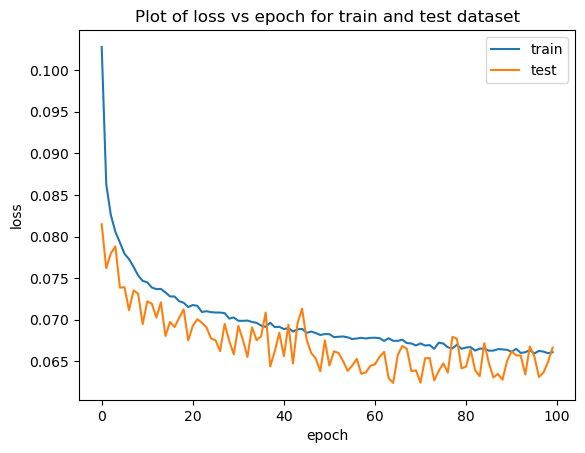

In [19]:
# Plot of loss vs epoch for train and test dataset
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()